In [19]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import glob
from tqdm import trange

Đọc đường dẫn ảnh

In [23]:
links = glob.glob('/kaggle/input/rice-image-dataset/Rice_Image_Dataset/**/*')
labels = [link.split('/')[-2] for link in links]
df = pd.DataFrame({'Đường dẫn': links, 'Nhãn': labels})
print(f'Số lượng ảnh {len(df)}')
df.sample(5)

Số lượng ảnh 75000


,Đường dẫn,Nhãn
52073,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
43183,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
36437,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine
55124,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Arborio
35158,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Jasmine


Xem mẫu

- Ảnh trước khi resize

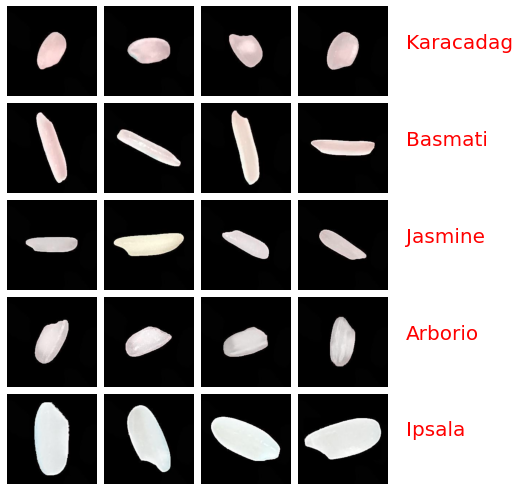

In [24]:
fig=plt.figure(1, figsize=(15,15))
grid=ImageGrid(fig,121, nrows_ncols=(5, 4), axes_pad=0.10)
i=0
for category_id, category in enumerate(df['Nhãn'].unique()):
    for filepath in df[df['Nhãn'] == category]['Đường dẫn'].values[:4]:
        ax = grid[i]
        img=cv2.imread(filepath)
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i % 4 == 4 - 1:
            ax.text(300, 100, category, verticalalignment='center',fontsize=20,color = 'red')
        i+=1
        
plt.show()

- Ảnh sau khi resize

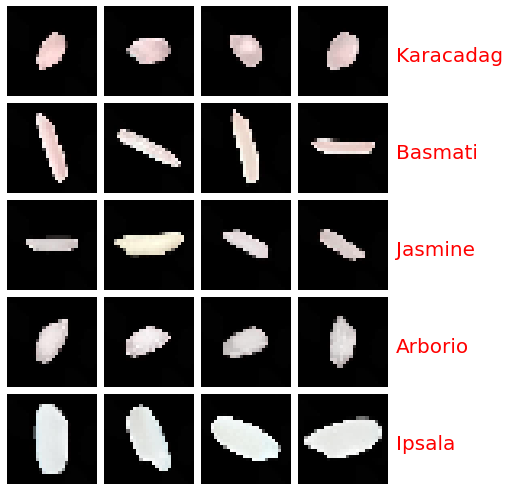

In [26]:
fig=plt.figure(1,figsize=(15,15))
grid=ImageGrid(fig,121, nrows_ncols=(5, 4), axes_pad=0.10)
i=0
for category_id, category in enumerate(df['Nhãn'].unique()):
    for filepath in df[df['Nhãn'] == category]['Đường dẫn'].values[:4]:
        ax = grid[i]
        img=cv2.imread(filepath)
        ax.imshow(cv2.resize(img, (28, 28)), cmap='gray')
        ax.axis('off')
        if i % 4 == 4 - 1:
            ax.text(30, 15, category, verticalalignment='center',fontsize=20,color = 'red')
        i+=1
plt.show()

Đọc lấy dữ liệu

In [59]:
import cv2
# định nghĩa nhãn
trans_labels = {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
# đọc ma trận ảnh
X = []; y=[]
for img, lb in zip(links, labels):
    mt = cv2.imread(img, 0)
    X.append(','.join(list(map(str, cv2.resize(mt, (28, 28)).ravel()))))
    y.append(trans_labels[lb])
# tạo dataframe
data = pd.DataFrame({'X': X, 'y': y})
# data

Xuất dữ liệu ra file .csv

In [60]:
data.to_csv('data_rice.csv', index=False)

Tạo tập Train, Test, Val

In [27]:
data = pd.read_csv('/kaggle/input/rice123/data_rice.csv')

In [28]:
def split_data(df, size_train = 0.8):
    '''
    return: df_train, df_test
    '''
    def sub_df(sub):
        train = sub.sample(frac=size_train)
        test =  sub.iloc[[i for i in sub.index if i not in train.index]]
        return train, test
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    for i in df.y.unique():
        df_train = pd.concat([df_train, sub_df(df[df.y == i].reset_index(drop=True))[0]])
        df_test = pd.concat([df_test, sub_df(df[df.y == i].reset_index(drop=True))[1]])
    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

In [29]:
df_train, df_test = split_data(data)
df_train, df_val = split_data(df_train, .9)

In [30]:
print(f'Số lượng dữ liệu:\n- Train: {len(df_train)}\n- Validation: {len(df_val)}\n- Test: {len(df_test)}')

Số lượng dữ liệu:
- Train: 54000
- Validation: 6000
- Test: 15000


Chuẩn hóa dữ liệu để đưa vào mô hình

In [31]:
def split_train_test(df):
    k = []
    for X in df.X.values:
        k.append([int(i) for i in X.split(',')])
    return np.array(k), df.y.values

In [32]:
X_train, y_train = split_train_test(df_train)
X_val, y_val = split_train_test(df_val)
X_test, y_test = split_train_test(df_test)

Xây dựng mô hình

In [33]:
np.random.seed(42)
lr = 0.005
class Layer:
    def __init__(self):
        self.weights = None
        self.bias = None
    
    def forward(self, input):
        output = np.matmul(input, self.weights) + self.bias
        return output
        
# Mỗi nơ-ron có một lớp được kết nối với mọi nơ-ron trong lớp ngay sau nó.
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.01):
        self.learning_rate = learning_rate
        
        # khỏi tạo weights và biases ngẫu nhiên
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
    
    # lan truyền tiến
    def forward(self,input):
        return np.matmul(input, self.weights) + self.biases
    # lan truyền ngược
    def backward(self,input,grad_output):
        grad_input = np.dot(grad_output,np.transpose(self.weights))

        # tính lại cac sweight và biases
        grad_weights = np.transpose(np.dot(np.transpose(grad_output),input))
        grad_biases = np.sum(grad_output, axis = 0)
        
        # cập nhật lại weight và biases
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        return grad_input

class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):

        return np.maximum(0,input)

    def backward(self, input, grad_output):

        relu_grad = input > 0
        return grad_output*relu_grad 
    

def softmax_crossentropy_with_logits(y_hat_logits,y):
    y_hat_logits_for_answers = y_hat_logits[np.arange(len(y_hat_logits)),y]
    xentropy = - y_hat_logits_for_answers + np.log(np.sum(np.exp(y_hat_logits),axis=-1))
    return xentropy

def grad_softmax_crossentropy_with_logits(y_hat_logits,y):
    ones_for_answers = np.zeros_like(y_hat_logits)
    ones_for_answers[np.arange(len(y_hat_logits)),y] = 1
    softmax = np.exp(y_hat_logits) / np.exp(y_hat_logits).sum(axis=-1,keepdims=True)
    return (- ones_for_answers + softmax) / y_hat_logits.shape[0]

def softmax(z):
    exp = np.exp(z - np.max(z))
    for i in range(len(z)):
        exp[i] /= np.sum(exp[i])
    return exp

network = []
network.append(Dense(X_train.shape[1], 256, lr))
network.append(ReLU())
network.append(Dense(256, 128, lr))
network.append(ReLU())
network.append(Dense(128, 64, lr))
network.append(ReLU())
network.append(Dense(64, 32, lr))
network.append(ReLU())
network.append(Dense(32 ,5, lr))

def forward(network, X):
    """
    Tính hàm kích hoạt của tất cả các lớp bằng cách áp dụng chúng một cách tuần tự.
    Trả về danh sách kích hoạt cho mỗi lớp.
    """
    activations = []
    input = X
    for i in range(len(network)):
        activations.append(network[i].forward(X))
        X = network[i].forward(X)
        
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Dự đoán đầu ra
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    
    # Dự đoán Xtrain[i] => đưa ra layer_activations
    layer_activations = forward(network,X)
    # Lấy dự đoán cuối cùng
    y_hat_logits = layer_activations[-1]
    
    # tính toán loss
    loss = softmax_crossentropy_with_logits(y_hat_logits,y)
    # loss=softmax(y_hat_logits)
    loss_grad = grad_softmax_crossentropy_with_logits(y_hat_logits,y)
    
    for i in range(1, len(network)):
        loss_grad = network[len(network) - i].backward(layer_activations[len(network) - i - 1], loss_grad)
    
    return np.mean(loss)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
            
        yield inputs[excerpt], targets[excerpt]
        

In [34]:
train_log = []
val_log = []
train_loss=[]
val_loss=[]
epochs=200
for epoch in range(epochs):
    tloss=[]
    vloss=[]
    print(f"epoch: {epoch+1}/{epochs}")
    
    for x_batch,y_batch in iterate_minibatches(X_train,y_train, batchsize=32, shuffle=True):
        train_lf=train(network,x_batch,y_batch)
        tloss.append(train_lf)
        
    for x_batch,y_batch in iterate_minibatches(X_val,y_val, batchsize=32, shuffle=True):
        val_lf=train(network,x_batch,y_batch)
        vloss.append(val_lf)
        
    train_loss.append(sum(tloss)/len(tloss))
    print(f"Train Loss: {train_loss[-1]}")
    val_loss.append(sum(vloss)/len(vloss))
    print(f"Val Loss: {val_loss[-1]}")
    train_log.append(np.mean(predict(network,X_train)==y_train))
    print(f"Train Accuracy: {train_log[-1]}")
    val_log.append(np.mean(predict(network,X_val)==y_val))
    print(f"Val Accuracy: {val_log[-1]}")

epoch: 1/200


100%|██████████| 187/187 [00:00<00:00, 394.23it/s]


Train Loss: 1.526664408021083
Val Loss: 1.207107281160082
Train Accuracy: 0.5123703703703704
Val Accuracy: 0.506
epoch: 2/200


100%|██████████| 187/187 [00:00<00:00, 370.59it/s]


Train Loss: 0.7424463013681437
Val Loss: 0.3094408606260766
Train Accuracy: 0.8948888888888888
Val Accuracy: 0.9038333333333334
epoch: 3/200


100%|██████████| 187/187 [00:00<00:00, 377.39it/s]


Train Loss: 0.23189998489032398
Val Loss: 0.17896359524169403
Train Accuracy: 0.9474259259259259
Val Accuracy: 0.9541666666666667
epoch: 4/200


100%|██████████| 187/187 [00:00<00:00, 375.10it/s]


Train Loss: 0.16259890412497405
Val Loss: 0.13830928871118367
Train Accuracy: 0.9304629629629629
Val Accuracy: 0.9338333333333333
epoch: 5/200


100%|██████████| 187/187 [00:00<00:00, 399.79it/s]


Train Loss: 0.1352681833158013
Val Loss: 0.12371709548922273
Train Accuracy: 0.9578518518518518
Val Accuracy: 0.9635
epoch: 6/200


100%|██████████| 187/187 [00:00<00:00, 345.90it/s]


Train Loss: 0.12176629175897179
Val Loss: 0.11242023452562623
Train Accuracy: 0.9558148148148148
Val Accuracy: 0.9611666666666666
epoch: 7/200


100%|██████████| 187/187 [00:00<00:00, 382.77it/s]


Train Loss: 0.11310693999462527
Val Loss: 0.10223662839370816
Train Accuracy: 0.9615370370370371
Val Accuracy: 0.9638333333333333
epoch: 8/200


100%|██████████| 187/187 [00:00<00:00, 369.38it/s]


Train Loss: 0.10787393232907418
Val Loss: 0.10113158608248857
Train Accuracy: 0.9660925925925926
Val Accuracy: 0.9705
epoch: 9/200


100%|██████████| 187/187 [00:00<00:00, 214.12it/s]


Train Loss: 0.10299276597796626
Val Loss: 0.0927266578635037
Train Accuracy: 0.9650185185185185
Val Accuracy: 0.9681666666666666
epoch: 10/200


100%|██████████| 187/187 [00:00<00:00, 378.49it/s]


Train Loss: 0.09936373189034908
Val Loss: 0.09152195728450026
Train Accuracy: 0.9625555555555556
Val Accuracy: 0.97
epoch: 11/200


100%|██████████| 187/187 [00:00<00:00, 360.93it/s]


Train Loss: 0.09715049147918794
Val Loss: 0.08847782507499269
Train Accuracy: 0.9703518518518518
Val Accuracy: 0.9731666666666666
epoch: 12/200


100%|██████████| 187/187 [00:00<00:00, 387.82it/s]


Train Loss: 0.09399337920509422
Val Loss: 0.08621338179635381
Train Accuracy: 0.971037037037037
Val Accuracy: 0.9746666666666667
epoch: 13/200


100%|██████████| 187/187 [00:00<00:00, 391.04it/s]


Train Loss: 0.09028181374737566
Val Loss: 0.08335581889164256
Train Accuracy: 0.9702592592592593
Val Accuracy: 0.9751666666666666
epoch: 14/200


100%|██████████| 187/187 [00:00<00:00, 384.58it/s]


Train Loss: 0.08977234576369506
Val Loss: 0.08275982605159697
Train Accuracy: 0.9708148148148148
Val Accuracy: 0.9741666666666666
epoch: 15/200


100%|██████████| 187/187 [00:00<00:00, 389.29it/s]


Train Loss: 0.08745165174689326
Val Loss: 0.07880121996211455
Train Accuracy: 0.9717037037037037
Val Accuracy: 0.9758333333333333
epoch: 16/200


100%|██████████| 187/187 [00:00<00:00, 234.28it/s]


Train Loss: 0.08596860700945747
Val Loss: 0.07620066016807918
Train Accuracy: 0.9733888888888889
Val Accuracy: 0.9768333333333333
epoch: 17/200


100%|██████████| 187/187 [00:00<00:00, 391.77it/s]


Train Loss: 0.08351566890734088
Val Loss: 0.07357030743337975
Train Accuracy: 0.9723703703703703
Val Accuracy: 0.978
epoch: 18/200


100%|██████████| 187/187 [00:00<00:00, 375.74it/s]


Train Loss: 0.0826986235892164
Val Loss: 0.07156836906211593
Train Accuracy: 0.9732592592592593
Val Accuracy: 0.9783333333333334
epoch: 19/200


100%|██████████| 187/187 [00:00<00:00, 361.00it/s]


Train Loss: 0.08089354438334799
Val Loss: 0.07139443792354651
Train Accuracy: 0.9749074074074074
Val Accuracy: 0.9796666666666667
epoch: 20/200


100%|██████████| 187/187 [00:00<00:00, 370.12it/s]


Train Loss: 0.07948946291467839
Val Loss: 0.06905011372990708
Train Accuracy: 0.9746296296296296
Val Accuracy: 0.9803333333333333
epoch: 21/200


100%|██████████| 187/187 [00:00<00:00, 378.78it/s]


Train Loss: 0.07844152119096803
Val Loss: 0.06967776897756388
Train Accuracy: 0.9765555555555555
Val Accuracy: 0.9813333333333333
epoch: 22/200


100%|██████████| 187/187 [00:00<00:00, 376.04it/s]


Train Loss: 0.07707028952969408
Val Loss: 0.0656940370014245
Train Accuracy: 0.9776296296296296
Val Accuracy: 0.9818333333333333
epoch: 23/200


100%|██████████| 187/187 [00:00<00:00, 381.02it/s]


Train Loss: 0.07629749075023744
Val Loss: 0.06896000917118207
Train Accuracy: 0.9755185185185186
Val Accuracy: 0.9801666666666666
epoch: 24/200


100%|██████████| 187/187 [00:00<00:00, 341.50it/s]


Train Loss: 0.07428166751429748
Val Loss: 0.06271407418698252
Train Accuracy: 0.9771111111111112
Val Accuracy: 0.9816666666666667
epoch: 25/200


100%|██████████| 187/187 [00:00<00:00, 198.46it/s]


Train Loss: 0.07318402207273281
Val Loss: 0.06140438282160303
Train Accuracy: 0.9761666666666666
Val Accuracy: 0.9818333333333333
epoch: 26/200


100%|██████████| 187/187 [00:00<00:00, 377.49it/s]


Train Loss: 0.07167161405260022
Val Loss: 0.05925520420647686
Train Accuracy: 0.9725555555555555
Val Accuracy: 0.9796666666666667
epoch: 27/200


100%|██████████| 187/187 [00:00<00:00, 385.70it/s]


Train Loss: 0.07144933483504604
Val Loss: 0.05994859374419453
Train Accuracy: 0.9796296296296296
Val Accuracy: 0.9853333333333333
epoch: 28/200


100%|██████████| 187/187 [00:00<00:00, 189.92it/s]


Train Loss: 0.07084273427491401
Val Loss: 0.05930350173285717
Train Accuracy: 0.9743518518518518
Val Accuracy: 0.9813333333333333
epoch: 29/200


100%|██████████| 187/187 [00:00<00:00, 356.74it/s]


Train Loss: 0.07009734411228385
Val Loss: 0.05592260994813091
Train Accuracy: 0.9707037037037037
Val Accuracy: 0.9758333333333333
epoch: 30/200


100%|██████████| 187/187 [00:00<00:00, 373.36it/s]


Train Loss: 0.06882679610209871
Val Loss: 0.05527966301129044
Train Accuracy: 0.9797222222222223
Val Accuracy: 0.9838333333333333
epoch: 31/200


100%|██████████| 187/187 [00:00<00:00, 296.65it/s]


Train Loss: 0.06725493096906979
Val Loss: 0.05590385885865935
Train Accuracy: 0.9788888888888889
Val Accuracy: 0.984
epoch: 32/200


 95%|█████████▍| 1596/1687 [00:04<00:00, 374.83it/s]


KeyboardInterrupt: 

Epoch 32
Train accuracy: 0.9788888888888889
Val accuracy: 0.984


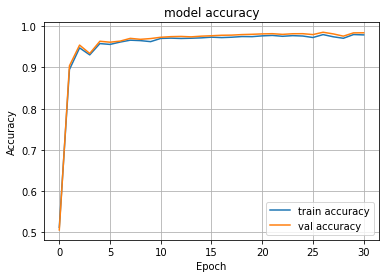

In [35]:
print("Epoch",epoch+1)
print("Train accuracy:",train_log[-1])
print("Val accuracy:", val_log[-1])
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.title("model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.show()

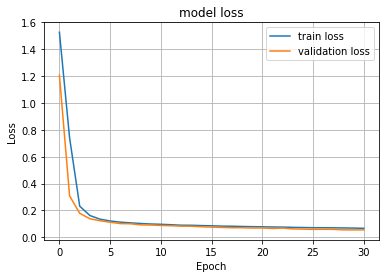

In [36]:
plt.plot(train_loss,label='train loss')
plt.plot(val_loss,label='validation loss')
plt.legend(loc='best')
plt.title("model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [16]:
lb_pre=predict(network,X_test)

In [37]:
len(y_test[lb_pre==y_test])/len(y_test)

0.9780666666666666

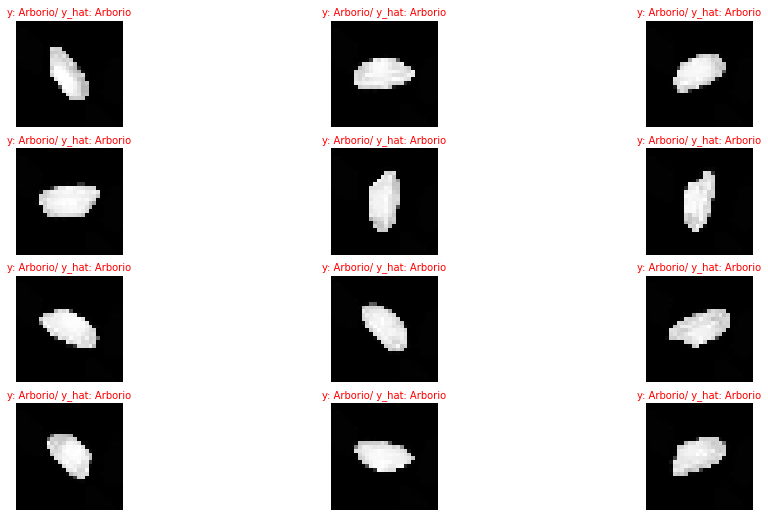

In [18]:
lb_pre=predict(network,X_test)
tenLb = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
fig=plt.figure(figsize=[16,9])
for i in range(12):
    ax=fig.add_subplot(4,3,i+1)
    ax.imshow(X_test[i].reshape([28,28]),cmap='gray')
    # plt.title(f"Label:{tenLb[lb_pre[i]]}")
    ax.set_title('y: {y}/ y_hat: {y_hat}'.format(y=tenLb[y_test[i]], y_hat=tenLb[lb_pre[i]]),fontsize=10,color='red')
    plt.axis('off')